### To do
- faire une PCA

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score
from sklearn.metrics import auc, confusion_matrix

### Loading the data

In [2]:
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)

# Données d'identification
id_list = ['an', 'dep', 'circo', 'code', 'nom', 'prenom', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['dep', 'circo', 'c_dep', 'code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 79)
Taille du DF après retrait des colonnes inutiles : (36919, 66)


In [3]:
def generate_df(raw_data, keep_list):
    # à garder obligatoirement pour identifier les lignes et créer les labels
    keep_list.extend(['an', 'nuance_groupe', 'p_inscrits', 'p_exprimes'])

    df = raw_data.drop([col for col in raw_data.columns if col not in keep_list], axis=1)
    #print(df.columns)

    # Gestion des NaN au niveau du score du candidat aux législatives précédentes
    years = [2002, 2007, 2012, 2017]

    # TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?
    if 'score_candidat_prec_leg' in keep_list:
        partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
                  'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_inscrits'][mask_2]) # moyenne des voix du parti 5 ans avant
                df.loc[mask, 'score_candidat_prec_leg'] = df['score_candidat_prec_leg'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_inscrits)
        #print('\nRemplissage des dernières valeurs manquantes pour la législative précédente avec {:.2f}%'.format(mean * 100))
        df.score_candidat_prec_leg = df.score_candidat_prec_leg.fillna(value=mean)

    # Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
    features_a_completer = ['chom_tot']
    for feature in features_a_completer:
        if feature in keep_list:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
            for year in years:
                mask = (df['an']==year)
                mean = np.mean(df[feature][mask])
                #print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
                df.loc[mask, feature] = df[feature][mask].fillna(value=mean)

    # Normaliser les votes


    # Catégorisation
    # df['score_candidat_prec_leg'] = pd.cut(df['score_candidat_prec_leg'], bins=[-1, -.01, .05, .1, .15, .2, 1],
    #                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

    df = df[df.an > 1997]
    df = df[df.nuance_groupe!='DIV'] # On retire les candidats "Divers" (pour l'entraînement ET la prédiction)
    
    print('Format du dataframe :', df.shape)
    #print(df.isnull().sum())
    
    return df

In [4]:
def train_val_splits(df, year_for_validation, target, scaler=MinMaxScaler()):
    # Liste des variables dummies et binaires pour les exclure de la normalisation
    dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes', 'dep', 'circo',
                    'geo_frontalier', 'geo_dom', 'geo_idf',
                    'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                    'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                    'circo_leg_meme_nuance',
                    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                    'nb_candidats_meme_bloc', 'score_candidat_prec_leg']
    scale_list = [col for col in df.columns if col not in dummies_list]

    print('Variables à normaliser', scale_list)
    df = pd.get_dummies(df, drop_first=True)
    
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    # Normalisation du dataframe
    X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
    X_val[scale_list] = scaler.transform(X_val[scale_list])

    print(X_train.shape, X_val.shape)
    print(y_train.shape, y_val.shape)
    
    return X_train, X_val, y_train, y_val

In [60]:
def get_classif(y_pred, y_val, id_val, target):
    from scipy.stats import rankdata
    
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['ecart'] = y_pred - res[target]
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        
        # normalisation des votes pour que la somme soit égale à 100%
        res.loc[res.code==circo, 'prediction'] /= np.sum(res.loc[res.code==circo, 'prediction'])
        
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
    return res

In [71]:
def analyze_predictions(df_predictions, target):
    n = df_predictions.shape[0]
    print('Prédictions pour {} candidats.'.format(n))

    ecarts_absolus = abs(df_predictions.ecart)
    max_ecart = np.max(ecarts_absolus)
    grid = np.arange(max_ecart, step=.01)
    ecarts_grid = []

    for point in grid:
        ecarts_grid.append(np.sum(ecarts_absolus < point))

    print('La MAE est : {:.2f}%'.format(
            mean_absolute_error(df_predictions[target], df_predictions.prediction) * 100))
    print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
    print('Le score AUC est : {:.2f}%'.format(auc(grid, ecarts_grid) * 100 / n))
    print('Le score r2 est : {:.2f}'.format(r2_score(df_predictions[target], df_predictions.prediction)))

    point_list = [.01, .02, .05, .1]
    ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

    plt.figure(1, figsize=(17, 3))
    plt.subplot(131)
    plt.plot(grid, ecarts_grid)
    for i in range(len(point_list)):
        plt.plot(point_list[i], ecart_list[i], 'ro')
        plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

    plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
    plt.xlabel('Seuils d\'erreur')

    plt.subplot(132)
    plt.hist(df_predictions['ecart'], bins=50)
    plt.title('Répartition globale des erreurs')

    # comparaison de la distribution des erreurs, parti par parti
    from scipy.stats import gaussian_kde
    plt.subplot(133)
    x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)

    nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'MDM': 'orange', 'UDI': 'yellow',
               'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
    for nuance in nuances:
        n_pred = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['qualif']=='E')
                               | (df_predictions['qualif']=='O'))].shape[0]
        n_reel = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['second_tour']=='E')
                               | (df_predictions['second_tour']=='O'))].shape[0]
        print('{}: {} prédits | Réel {}'.format(nuance, n_pred, n_reel))
        try: # cas où le parti n'est pas représenté à l'élection prédite
            pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                               bw_method=.9).evaluate(x_grid)
            plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)
        except:
            pass

    plt.title('Répartition des erreurs selon le parti')
    plt.legend(loc='best')

    n_correct = np.sum(df_predictions.second_tour == df_predictions.qualif)
    print('\n{} prédictions correctes sur {} (soit {:.1f}%)'.format(n_correct, n, 100 * n_correct / n))

    print('\nMatrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
    cm = confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])
    print(cm)

    f1_E = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='E', average='micro')
    print('Score F1 pour la classe E : {:.1f}%'.format(f1_E * 100))
    f1_O = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='O', average='micro')
    print('Score F1 pour la classe O : {:.1f}%'.format(f1_O * 100))
    f1_N = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='N', average='micro')
    print('Score F1 pour la classe N : {:.1f}%'.format(f1_N * 100))
    plt.show()
    
    return

### Choix des paramètres

In [62]:
# Sélection des features
keep_list = [#'geo_frontalier', 'geo_dom', 'geo_idf',
    'part_impose', 'chom_tot',
    #'p_agri',
    'p_ouvriers',
    #'d_brevet',
    'd_sup',
    'circo_leg_meme_nuance', 'circo_meme_nuance_president', 'circo_pres_meme_nuance',
    'nb_candidats_meme_bloc',
    'score_nuance_groupe_pres',
    'score_candidat_prec_leg',
    #'score_nuance_groupe_prec_leg', #(un peu mauvais)
    #'score_bloc_pres', 'score_bloc_prec_leg', #(mauvais pour le score)
    'nuance_groupe',
    #'taux_vote_pres', 'taux_vote_leg',
    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre',
    'membre_majorite',
    'sexe'
]

scaler = MinMaxScaler()
#scaler = StandardScaler()
target_values = 'p_exprimes' # 'p_inscrits'
target_year = 2012

In [63]:
df = generate_df(raw, keep_list)
X_train, X_val, y_train, y_val = train_val_splits(df, target_year, target_values, scaler)

Format du dataframe : (26396, 20)
Variables à normaliser ['part_impose', 'chom_tot', 'p_ouvriers', 'd_sup', 'score_nuance_groupe_pres']
(13689, 31) (6024, 31)
(13689,) (6024,)


In [64]:
X_train.head(2)

,part_impose,chom_tot,p_ouvriers,d_sup,circo_leg_meme_nuance,nb_candidats_meme_bloc,circo_pres_meme_nuance,circo_meme_nuance_president,score_nuance_groupe_pres,score_candidat_prec_leg,...,nuance_groupe_EXG,nuance_groupe_FI,nuance_groupe_FN,nuance_groupe_LR,nuance_groupe_MDM,nuance_groupe_RDG,nuance_groupe_REG,nuance_groupe_REM,nuance_groupe_SOC,nuance_groupe_UDI
14488,0.546669,0.061475,0.598684,0.331373,0.0,3.0,0.0,0.0,0.018692,0.036679,...,0,0,0,0,0,0,0,0,0,0
14489,0.546669,0.061475,0.598684,0.331373,1.0,2.0,1.0,0.0,0.481142,0.223836,...,0,0,0,1,0,0,0,0,0,0


### Choix de modèle

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
#sorted(list(zip(rf.feature_importances_*100, X_train.columns)), reverse=True)

In [195]:
# from sklearn.svm import SVR
# reg = SVR()
# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_val)

In [65]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor((100, 100), activation='relu', solver='adam', alpha=0.001, batch_size=500,
                   learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000, tol=1e-7, verbose=True,
                  power_t=.5, early_stopping=False)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

Iteration 1, loss = 0.06204321
Iteration 2, loss = 0.00176426
Iteration 3, loss = 0.00126751
Iteration 4, loss = 0.00120668
Iteration 5, loss = 0.00117290
Iteration 6, loss = 0.00114170
Iteration 7, loss = 0.00111831
Iteration 8, loss = 0.00110552
Iteration 9, loss = 0.00109948
Iteration 10, loss = 0.00108282
Iteration 11, loss = 0.00106120
Iteration 12, loss = 0.00105092
Iteration 13, loss = 0.00105358
Iteration 14, loss = 0.00103284
Iteration 15, loss = 0.00103548
Iteration 16, loss = 0.00101684
Iteration 17, loss = 0.00101697
Iteration 18, loss = 0.00101424
Iteration 19, loss = 0.00102988
Iteration 20, loss = 0.00099753
Iteration 21, loss = 0.00099272
Iteration 22, loss = 0.00100561
Iteration 23, loss = 0.00101973
Iteration 24, loss = 0.00098865
Iteration 25, loss = 0.00098365
Iteration 26, loss = 0.00098966
Iteration 27, loss = 0.00098799
Iteration 28, loss = 0.00096881
Iteration 29, loss = 0.00097050
Iteration 30, loss = 0.00096816
Iteration 31, loss = 0.00096617
Iteration 32, los

Prédictions pour 6024 candidats.
La MAE est : 3.66%
La plus grosse erreur est : 44.61%
Le score AUC est : 40.60%
Le score r2 est : 0.77
ECO: 5 prédits | Réel 44
MDM: 6 prédits | Réel 12
FI: 25 prédits | Réel 12
SOC: 457 prédits | Réel 427
LR: 435 prédits | Réel 422
FN: 8 prédits | Réel 59
DLF: 1 prédits | Réel 1
REG: 1 prédits | Réel 4
UDI: 29 prédits | Réel 45

5564 prédictions correctes sur 6024 (soit 92.4%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  19   17    0]
 [ 116  744  219]
 [   1  107 4801]]
Score F1 pour la classe E : 22.1%
Score F1 pour la classe O : 76.4%
Score F1 pour la classe N : 96.7%


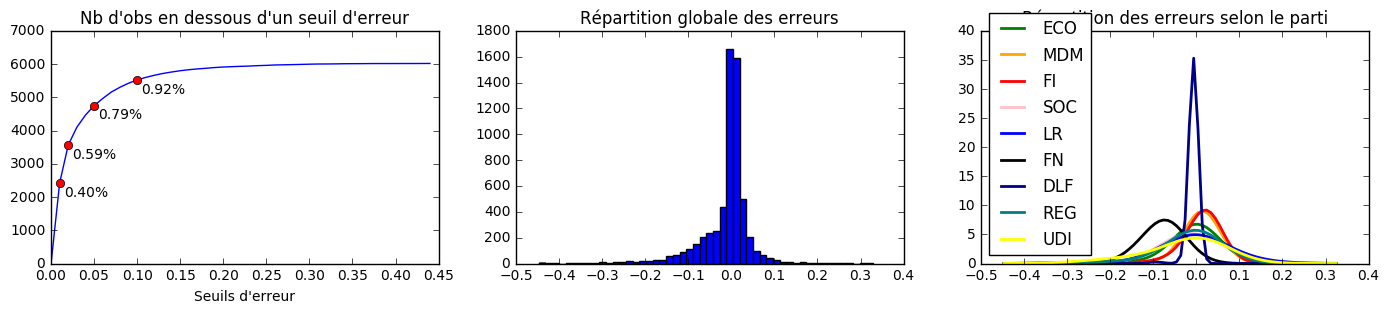

In [72]:
df_predictions = get_classif(y_pred, y_val, df_id, target_values)
analyze_predictions(df_predictions, target_values)

In [67]:
df_predictions.sort_values(by='ecart').head(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
13113,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,GIRARDIN,ANNICK,RDG,0.5186,E,0.6552,0.399334,-0.446149,1,O
12340,2012,PARIS,6,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.093496,-0.437746,3,N
10982,2012,LA-REUNION,2,974|2,BELLO,HUGUETTE,DVG,0.4562,E,0.6712,0.239174,-0.425749,2,O


In [184]:
df_predictions.sort_values(by='ecart').tail(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
11564,2012,MARTINIQUE,2,972|2,LEBON,FRANTZ,SOC,0.3253,N,0.0218,0.29476,0.27296,1,O
9853,2012,GUADELOUPE,2,971|2,COUCHY,CHRISTIAN,SOC,0.2982,N,0.0362,0.30947,0.27327,1,O
12030,2012,NORD,10,59|10,VANNESTE,CHRISTIAN,DVD,0.4669,N,0.1311,0.41084,0.27974,1,O


#### Save predictions

In [69]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))